In [57]:
import sys
sys.path.append('../')

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from csbdeep.utils import move_image_axes, normalize
from glob import glob
from skimage import io
from stardist.matching import matching_dataset
from stardist.models import StarDist2D
from tqdm import tqdm

from utils import save_scores_csv, show_test_images, taus

In [58]:
image_dir = '/storage/annajiwons/images'
merfish_dir = f'{image_dir}/merfish'
smfish_dir = f'{image_dir}/probe_and_nuclei'

model_dir = './models'

In [59]:
# 8 images (20%) chosen for test
X_test_names = sorted(glob(f'{smfish_dir}/test/*.tif'))
X_test = [normalize(img, 1, 99.8, axis=(0, 1)) for img in list(map(io.imread, X_test_names))]
X_test = [move_image_axes(x, 'CYX', 'YXC') for x in X_test]
Y_test_names = sorted(glob(f'{merfish_dir}/test/masks/*.tif'))
Y_test = list(map(io.imread, Y_test_names))

In [60]:
# Load from disk
probe_and_nuclei_model = StarDist2D(None, name='probe_and_nuclei_model', basedir=model_dir) 

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.73508, nms_thresh=0.3.


In [61]:
Y_pred = [probe_and_nuclei_model.predict_instances(x, n_tiles=probe_and_nuclei_model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test)]

100%|██████████| 8/8 [02:08<00:00, 16.03s/it]


In [62]:
Y_pred_labels = [pred[0] for pred in Y_pred]
stats = [matching_dataset(Y_test, Y_pred_labels, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


In [63]:
stats

[DatasetMatching(criterion='iou', thresh=0.1, fp=4, tp=40, fn=3, precision=0.9090909090909091, recall=0.9302325581395349, accuracy=0.851063829787234, f1=0.9195402298850575, n_true=43, n_pred=44, mean_true_score=0.7562302459578563, mean_matched_score=0.8129475144046955, panoptic_quality=0.7475379442801797, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.2, fp=4, tp=40, fn=3, precision=0.9090909090909091, recall=0.9302325581395349, accuracy=0.851063829787234, f1=0.9195402298850575, n_true=43, n_pred=44, mean_true_score=0.7562302459578563, mean_matched_score=0.8129475144046955, panoptic_quality=0.7475379442801797, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.3, fp=4, tp=40, fn=3, precision=0.9090909090909091, recall=0.9302325581395349, accuracy=0.851063829787234, f1=0.9195402298850575, n_true=43, n_pred=44, mean_true_score=0.7562302459578563, mean_matched_score=0.8129475144046955, panoptic_quality=0.7475379442801797, by_image=False),
 DatasetMatching(criterion='

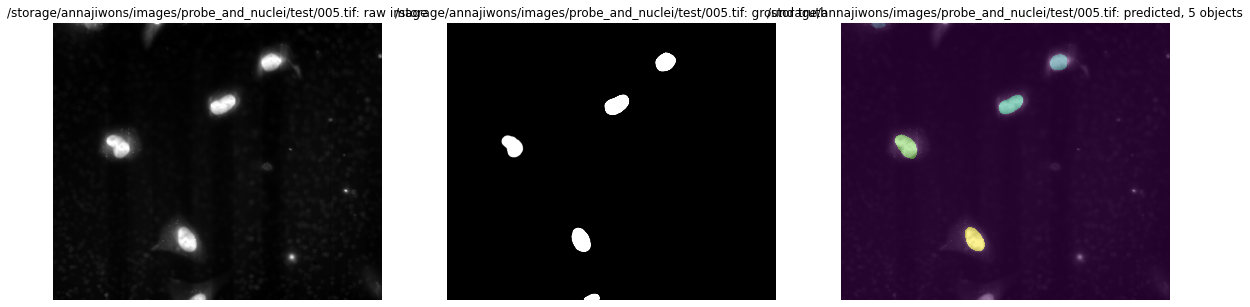

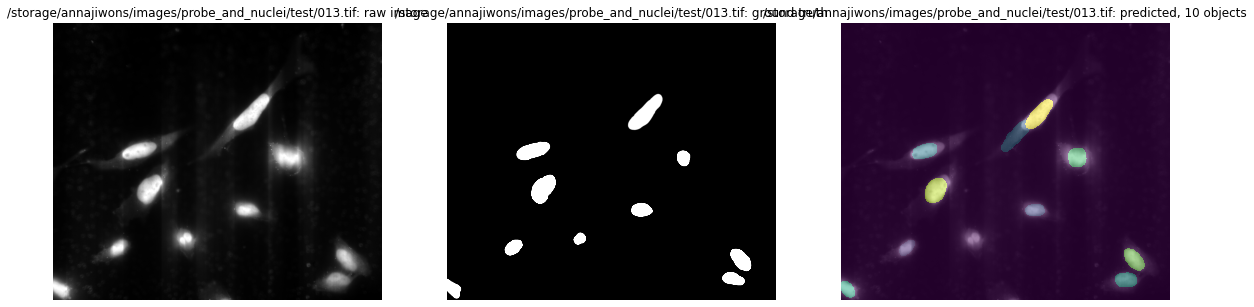

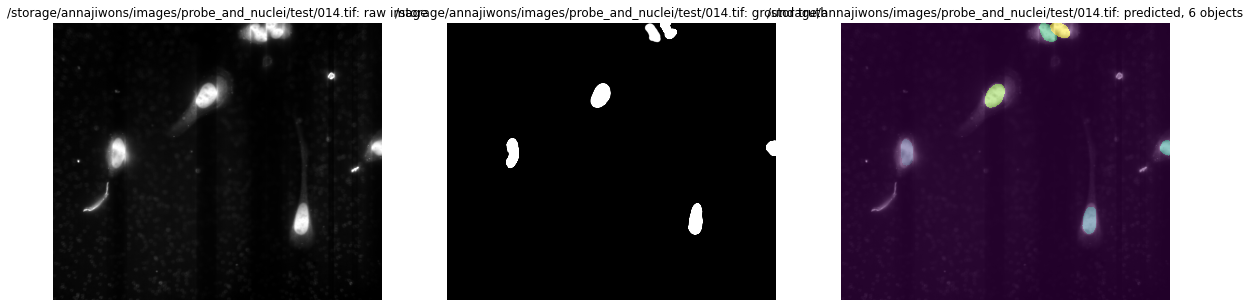

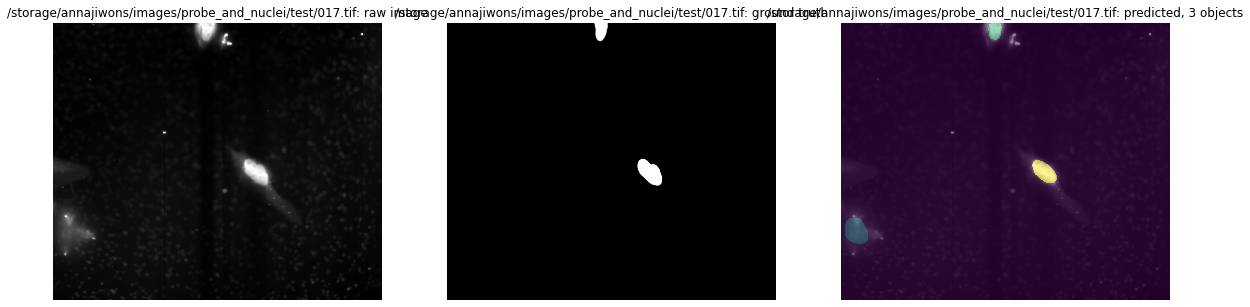

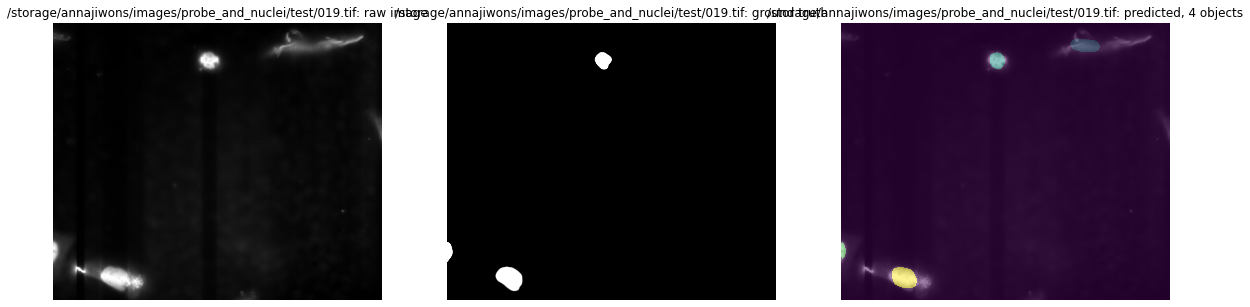

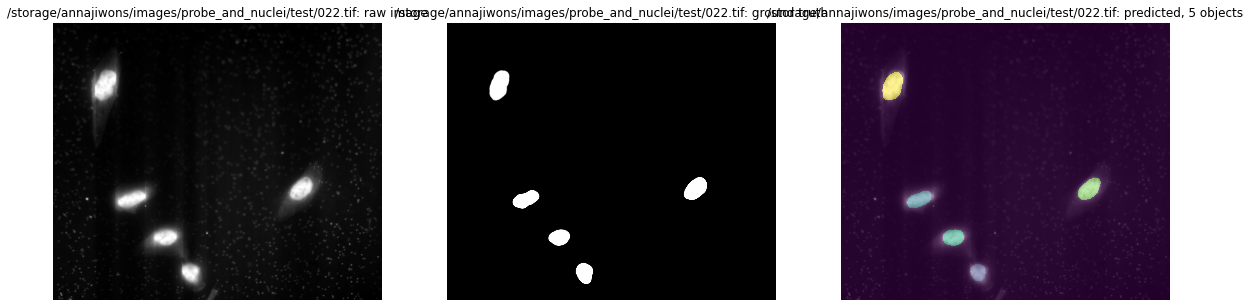

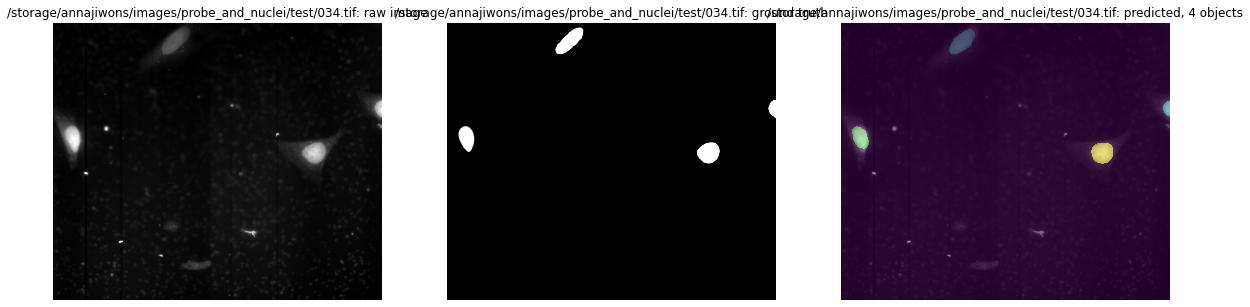

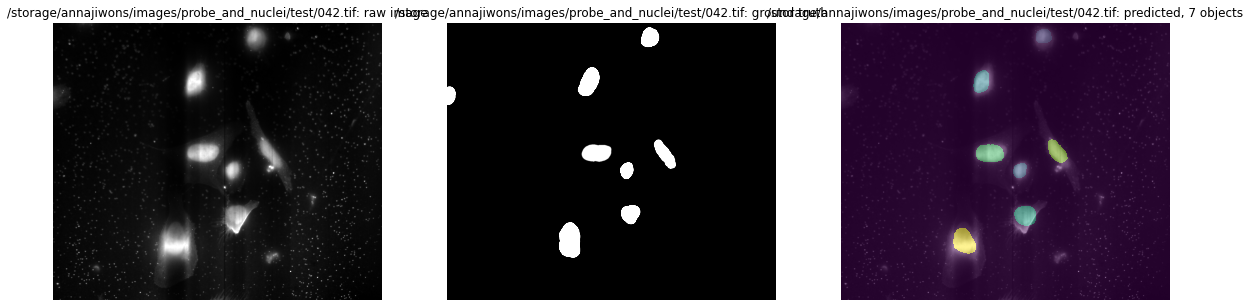

In [64]:
for i in range(len(X_test)):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(X_test[i][:,:,0], clim=(0,1), cmap='gray') # Plot nuclei channel only
    axes[0].set_title(f'{X_test_names[i]}: raw image')
    axes[0].axis('off')
    
    axes[1].imshow(Y_test[i], clim=(0,1), cmap='gray')
    axes[1].set_title(f'{X_test_names[i]}: ground truth')
    axes[1].axis('off')
    
    axes[2].imshow(X_test[i][:,:,0], clim=(0,1), cmap='gray')
    axes[2].imshow(Y_pred[i][0], interpolation="nearest", alpha=0.5)
    num_objects = len(Y_pred[i][1]['coord'])
    axes[2].set_title(f'{X_test_names[i]}: predicted, {num_objects} objects')
    axes[2].axis('off')

In [65]:
save_scores_csv(stats)

In [66]:
cv.imwrite('model11.tif', Y_pred[1][0])

True